In [1]:
#!/usr/bin/env python3
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import IPython.display
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from keras import regularizers

Using TensorFlow backend.


In [2]:
# key issues:
# what does accuracy mean in a regression problem? are we calculting the idea correctly?
# 

In [3]:
files = "./data/merged.csv"

# accleration file
# file_accel = "./data/accel-merge.csv"

# raw_dataset_accel = pd.read_csv(file_accel, sep=",", skipinitialspace=True)
# dataset_accel =raw_dataset_accel.copy()
# dataset_no_speed = dataset_accel
# dataset_no_speed.pop('Vehicle speed (MPH)')

raw_dataset = pd.read_csv(files, sep=",", skipinitialspace=True)
dataset = raw_dataset.copy()

#remove whitespace in front of column name
dataset.columns = dataset.columns.str.lstrip()
# dataset_accel.columns = dataset_accel.columns.str.lstrip()

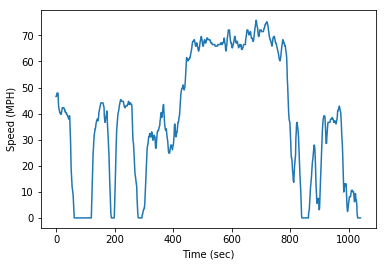

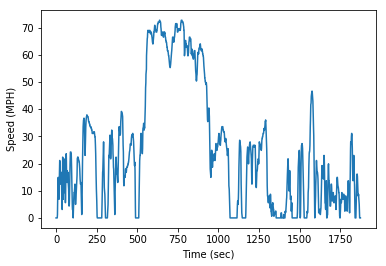

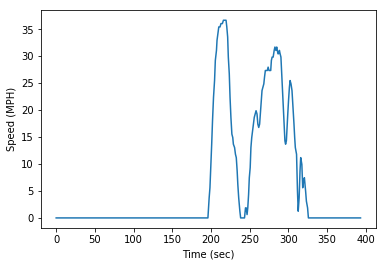

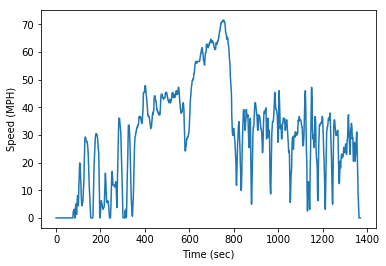

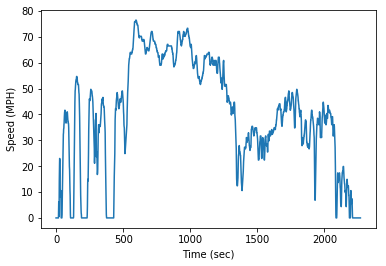

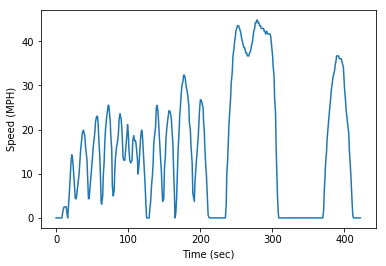

In [5]:
# adding speed and accel decreased performance
file_no_merge = ["./data/{}-Cleaned.csv".format(i) for i in range(1, 7)]

def plot_speed_time(files):
    raw_dataset = pd.read_csv(files, sep=",", skipinitialspace=True)
    dataset = raw_dataset.copy()
    
    time = dataset.pop("Time (sec)")
    time.tail()
    speed = dataset.pop("Vehicle speed (MPH)")
    
   
    plt.xlabel("Time (sec)")
    plt.ylabel("Speed (MPH)")
    plt.plot(time, speed)
    plt.show()
    
for file in file_no_merge:
    plot_speed_time(file)

In [4]:
# Global parameters
seed = 9

In [6]:
# Delete this in future?

#To-do: consider experimenting what happens when you remove it.
#if the maxNum = 45, there are ___1788___ obs whose MPG > 45

#a function that rounds down any value above 45 to 45.
#39 is the avg highway IFE. we then choose the number 45.
#see our doc/write up for more info?

# def set_max_ife(dataset, max_num, wanted):
#     #    count = 0
#     if not wanted: return dataset
#     copy = dataset.copy()
#     for i in range(len(dataset.index)):
#         if dataset.iloc[i, len(dataset.columns) - 1] > max_Num:
# #            count += 1
#             copy.iloc[i, len(dataset.columns) - 1] = max_Num
# #    print(count)
#     return copy
# maxed_dataset = set_max_ife(dataset, max_num, False)
# maxed_dataset.sample(frac=1).reset_index(drop=True)

In [7]:
#Plotting a histograph to see distribution of Vehicle speed (MPH) 
#sns.distplot(maxedDataSet['Vehicle speed (MPH)']);

In [8]:
#print(list_highway_speed)
#for i in range(1,len(list_highway_speed))):
#    highway_speed_dataset = maxed_dataset[list_highway_speed[i]]


In [5]:
%%time 
#set seed here!
# dataset_accel = dataset_accel.sample(frac=1).reset_index(drop=True)
# dataset_no_speed = dataset_no_speed.sample(frac=1).reset_index(drop=True)

#creating data and splitting and random shuffling
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.loc[perm[:train_end]]
    validate = df.loc[perm[train_end:validate_end]]
    test = df.loc[perm[validate_end:]]
    return train, validate, test

np.random.seed(88)
# dataset = dataset.sample(frac=1).reset_index(drop=True)
train, validate, test = train_validate_test_split(dataset)

train_labels = train.pop("Instant fuel economy (MPG)")
validate_labels = validate.pop("Instant fuel economy (MPG)")
test_labels = test.pop("Instant fuel economy (MPG)")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.18 ms


In [ ]:
train = train.apply(lambda col:pd.to_numeric(col, errors='coerce'))

# train_stats is a pandas data frame type
train_stats = train.describe(include = 'all')
train_stats

train_stats['Vehicle speed (MPH)']

In [ ]:
train_stats['Vehicle speed (MPH)'][1] #mean

In [6]:
#we have to normalize test and validation data set by using the mean and sd from training data set
def getMean(column):
    sum = 0
    n = len(column)
    for i in range(n):
        sum += column.iloc[i]
    mean = sum / float(n)
    return mean

def getVariance(column, mean):
    squareMeanSum = 0
    n = len(column)
    for i in range(n):
        squareMeanSum += (column.iloc[i] - mean)**2
    var = math.sqrt(squareMeanSum / float(n))
    return var

# Normalize function from sklearn was buggy so we wrote our own
# Given a data set, normalize it and return the normalized data set
def normalizeSet(set):
    numRow = len(set.index)
    numCol = len(set.columns)
#     normed_set = set
    for col in range(numCol):
        column = set.iloc[:,col]
        mean = getMean(column)
        var = getVariance(column, mean)        
#         normalize each each value in a particular feature 
        for row in range(numRow):
            set.iloc[row, col] = float(set.iloc[row, col] - mean) / var
#             normed_set.iloc[row, col] = float(set.iloc[row, col] - mean) / var
#             print(set.iloc[row, col])
    return set
normed_train = normalizeSet(train)
normed_validate = normalizeSet(validate)
normed_test = normalizeSet(test)

In [46]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

#     plt.figure()
#     plt.xlabel('Epoch')
#     plt.ylabel('Mean Abs Error [MPG]')
#     plt.plot(hist['epoch'], hist['mean_absolute_error'],
#            label='Train Error')
#     plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
#            label = 'Val Error')
#     plt.ylim([0,30])
#     plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.xlim([0,epochs])
    plt.ylim([0, 8000])
    plt.legend()
    plt.show()

def getHist(test_predictions, test_labels):
    error = test_predictions - test_labels
    plt.xlabel("Prediction Error [MPG]")
    _ = plt.ylabel("Count")
    plt.hist(error, bins = 25)
    return error

def plot_scatter(test_predictions):
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values [MPG]')
    plt.ylabel('Predictions [MPG]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-100, 100], [-100, 100])

def calculate_percent_error(test_predictions, test_labels):
    difference = abs(test_predictions - test_labels)
    error = difference / test_labels
    unprocessed_error_percentage = error * 100
    np_error = np.array(unprocessed_error_percentage)
    a = np.ma.masked_invalid(np_error)
    error_percentage = a.sum() / (len(unprocessed_error_percentage) - np.count_nonzero(np.isinf(unprocessed_error_percentage)))
    print("Percentage Error: {}%".format(error_percentage))
    return (error_percentage)

def compute_acc(error_percentage):
    accuracy = 100 - error_percentage
    print("Test Accuracy: {}%".format(accuracy))

In [36]:
epochs = 250
learning_rate = 0.001
reg = 0.01

In [16]:
# build models with different number of activation layers and number of nodes to explore
# which one has lowest testing error
def build_model_A():
    model = keras.Sequential([
    layers.Dense(5, activation=tf.nn.relu, input_shape=[len(train.keys())]),
    layers.Dense(1)
  ])
    optimizer = tf.keras.optimizers.RMSprop(learning_rate)
    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

def build_model_B():
    model = keras.Sequential([
    layers.Dense(20, activation=tf.nn.relu, input_shape=[len(train.keys())]),
    layers.Dense(1)
  ])
    optimizer = tf.keras.optimizers.RMSprop(learning_rate)
    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return model


def build_model_C(reg):
    model = keras.Sequential([
    layers.Dense(15, activation=tf.nn.relu, use_bias=True, activity_regularizer=regularizers.l2(reg),input_shape=[len(train.keys())]),
    layers.Dense(10, activation=tf.nn.relu, use_bias=True,activity_regularizer=regularizers.l2(reg)),
    layers.Dense(5, activation=tf.nn.relu, use_bias=True,activity_regularizer=regularizers.l2(reg)),
    layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(learning_rate)
    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['acc', 'mean_squared_error'])
    return model

def build_model_D(reg):
    model = keras.Sequential([
    layers.Dense(330, activation=tf.nn.relu, use_bias=True, activity_regularizer=regularizers.l2(reg),input_shape=[len(train.keys())]),
    layers.Dense(330, activation=tf.nn.relu, use_bias=True,activity_regularizer=regularizers.l2(reg)),
    layers.Dense(330, activation=tf.nn.relu, use_bias=True,activity_regularizer=regularizers.l2(reg)),
    layers.Dense(330, activation=tf.nn.relu, use_bias=True,activity_regularizer=regularizers.l2(reg)),
    layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate)
    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['acc', 'mean_squared_error'])
    return model


In [18]:
# reformatting all the code due to a "memory" bug where ipython keeps the same weights 
# as the previous model, causeing issues

In [42]:
%%time
model_A = build_model_A()

CPU times: user 156 ms, sys: 46.9 ms, total: 203 ms
Wall time: 172 ms


In [43]:
%%time
history_object_A = model_A.fit(normed_train, train_labels, epochs=epochs, verbose=1,
         validation_data=(normed_validate, validate_labels))

Train on 2916 samples, validate on 972 samples
Epoch 1/250
2916/2916 [==============================] - 0s 109us/sample - loss: 9834.6087 - mean_absolute_error: 56.5862 - mean_squared_error: 9834.6074 - val_loss: 9588.3989 - val_mean_absolute_error: 57.6063 - val_mean_squared_error: 9588.3984
Epoch 2/250
2916/2916 [==============================] - 0s 51us/sample - loss: 9746.3517 - mean_absolute_error: 56.1251 - mean_squared_error: 9746.3486 - val_loss: 9502.8453 - val_mean_absolute_error: 57.2158 - val_mean_squared_error: 9502.8438
Epoch 3/250
2916/2916 [==============================] - 0s 43us/sample - loss: 9670.3104 - mean_absolute_error: 55.7572 - mean_squared_error: 9670.3105 - val_loss: 9420.9266 - val_mean_absolute_error: 56.8382 - val_mean_squared_error: 9420.9268
Epoch 4/250
2916/2916 [==============================] - 0s 49us/sample - loss: 9593.3037 - mean_absolute_error: 55.4068 - mean_squared_error: 9593.3027 - val_loss: 9339.5706 - val_mean_absolute_error: 56.4931 - va

2916/2916 [==============================] - 0s 46us/sample - loss: 4777.2130 - mean_absolute_error: 36.0193 - mean_squared_error: 4777.2139 - val_loss: 4319.4160 - val_mean_absolute_error: 36.3147 - val_mean_squared_error: 4319.4155
Epoch 35/250
2916/2916 [==============================] - 0s 49us/sample - loss: 4625.9142 - mean_absolute_error: 35.2502 - mean_squared_error: 4625.9136 - val_loss: 4164.1952 - val_mean_absolute_error: 35.5512 - val_mean_squared_error: 4164.1953
Epoch 36/250
2916/2916 [==============================] - 0s 54us/sample - loss: 4484.0008 - mean_absolute_error: 34.5185 - mean_squared_error: 4483.9995 - val_loss: 4017.3182 - val_mean_absolute_error: 34.8280 - val_mean_squared_error: 4017.3184
Epoch 37/250
2916/2916 [==============================] - 0s 46us/sample - loss: 4345.9500 - mean_absolute_error: 33.8489 - mean_squared_error: 4345.9487 - val_loss: 3877.3901 - val_mean_absolute_error: 34.1469 - val_mean_squared_error: 3877.3899
Epoch 38/250
2916/2916 [=

2916/2916 [==============================] - 0s 45us/sample - loss: 2603.1918 - mean_absolute_error: 23.5197 - mean_squared_error: 2603.1914 - val_loss: 2101.1542 - val_mean_absolute_error: 23.1358 - val_mean_squared_error: 2101.1541
Epoch 101/250
2916/2916 [==============================] - 0s 39us/sample - loss: 2596.1385 - mean_absolute_error: 23.4689 - mean_squared_error: 2596.1387 - val_loss: 2093.5968 - val_mean_absolute_error: 23.0905 - val_mean_squared_error: 2093.5967
Epoch 102/250
2916/2916 [==============================] - 0s 40us/sample - loss: 2590.2644 - mean_absolute_error: 23.4359 - mean_squared_error: 2590.2644 - val_loss: 2087.1317 - val_mean_absolute_error: 23.0127 - val_mean_squared_error: 2087.1316
Epoch 103/250
2916/2916 [==============================] - 0s 41us/sample - loss: 2583.8769 - mean_absolute_error: 23.3704 - mean_squared_error: 2583.8770 - val_loss: 2080.5581 - val_mean_absolute_error: 22.9666 - val_mean_squared_error: 2080.5581
Epoch 104/250
2916/291

2916/2916 [==============================] - 0s 39us/sample - loss: 2269.4058 - mean_absolute_error: 20.8415 - mean_squared_error: 2269.4058 - val_loss: 1793.2331 - val_mean_absolute_error: 20.4440 - val_mean_squared_error: 1793.2329
Epoch 167/250
2916/2916 [==============================] - 0s 39us/sample - loss: 2267.9663 - mean_absolute_error: 20.8411 - mean_squared_error: 2267.9663 - val_loss: 1791.3489 - val_mean_absolute_error: 20.4348 - val_mean_squared_error: 1791.3490
Epoch 168/250
2916/2916 [==============================] - 0s 40us/sample - loss: 2264.8562 - mean_absolute_error: 20.8339 - mean_squared_error: 2264.8557 - val_loss: 1789.1733 - val_mean_absolute_error: 20.3932 - val_mean_squared_error: 1789.1733
Epoch 169/250
2916/2916 [==============================] - 0s 39us/sample - loss: 2262.4253 - mean_absolute_error: 20.8433 - mean_squared_error: 2262.4250 - val_loss: 1787.6079 - val_mean_absolute_error: 20.3092 - val_mean_squared_error: 1787.6080
Epoch 170/250
2916/291

2916/2916 [==============================] - 0s 38us/sample - loss: 2145.6113 - mean_absolute_error: 19.6395 - mean_squared_error: 2145.6116 - val_loss: 1707.8943 - val_mean_absolute_error: 19.4797 - val_mean_squared_error: 1707.8942
Epoch 233/250
2916/2916 [==============================] - 0s 41us/sample - loss: 2145.4348 - mean_absolute_error: 19.5417 - mean_squared_error: 2145.4346 - val_loss: 1706.1422 - val_mean_absolute_error: 19.6263 - val_mean_squared_error: 1706.1421
Epoch 234/250
2916/2916 [==============================] - 0s 40us/sample - loss: 2143.7668 - mean_absolute_error: 19.6156 - mean_squared_error: 2143.7666 - val_loss: 1705.9817 - val_mean_absolute_error: 19.5607 - val_mean_squared_error: 1705.9816
Epoch 235/250
2916/2916 [==============================] - 0s 39us/sample - loss: 2141.2548 - mean_absolute_error: 19.6377 - mean_squared_error: 2141.2546 - val_loss: 1705.5300 - val_mean_absolute_error: 19.5421 - val_mean_squared_error: 1705.5298
Epoch 236/250
2916/291

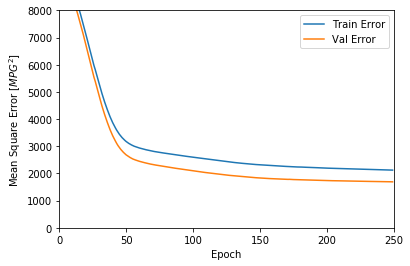

In [47]:
plot_history(history_object_A)

Percentage Error: 57.80897060537605%
Test Accuracy: 42.19102939462395%


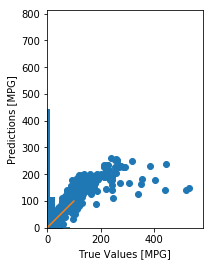

In [45]:
test_predictions_A = model_A.predict(normed_test).flatten()
error_A = getHist(test_predictions_A, test_labels)
plot_scatter(test_predictions_A)
p_err_A = calculate_percent_error(test_predictions_A, test_labels)
compute_acc(p_err_A)

In [78]:
model_B = build_model_B()

In [ ]:
%%time
# See where the error jumps on a particular example (maybe jumps when on high way or city)
history_object_B = model_B.fit(normed_train, train_labels, epochs=epochs, verbose=2,
         validation_data=(normed_validate, validate_labels))

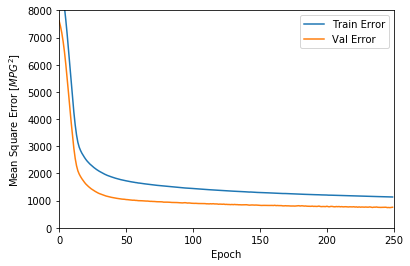

In [80]:
plot_history(history_object_B)

Percentage Error: 42.86258095805907%
Test Accuracy: 57.13741904194093%


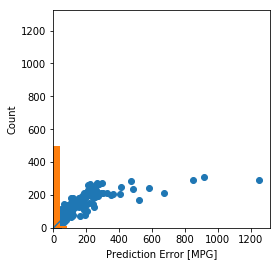

In [81]:
test_predictions_B = model_B.predict(normed_test).flatten()
plot_scatter(test_predictions_B)
error_B = getHist(test_predictions_B, test_labels)
p_err_B = calculate_percent_error(test_predictions_B, test_labels)
compute_acc(p_err_B)

In [88]:
model_C = build_model_C(reg=0.1)

In [ ]:
%%time
# See where the error jumps on a particular example (maybe jumps when on high way or city)
history_object_C = model_C.fit(normed_train, train_labels, epochs=epochs, verbose=2,
         validation_data=(normed_validate, validate_labels))

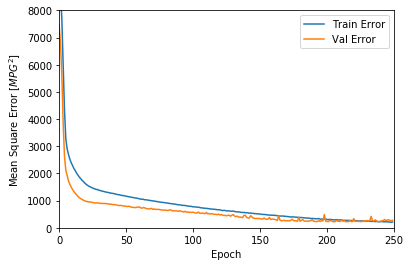

In [90]:
plot_history(history_object_C)

Percentage Error: 25.085029867874706%
Test Accuracy: 74.91497013212529%


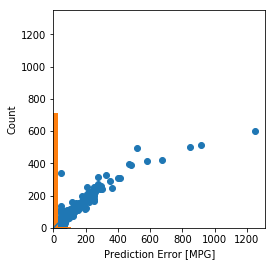

In [91]:
test_predictions_C = model_C.predict(normed_test).flatten()
plot_scatter(test_predictions_C)
errorC = getHist(test_predictions_C, test_labels)
p_err_C = calculate_percent_error(test_predictions_C, test_labels)
compute_acc(p_err_C)

In [17]:
model_D = build_model_D(reg=0.01)

In [ ]:
%%time
history_object_D = model_D.fit(normed_train, train_labels, epochs=130, verbose=2,
         validation_data=(normed_validate, validate_labels))

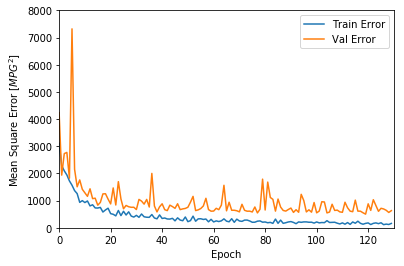

In [40]:
plot_history(history_object_D)

In [1]:
test_predictions_D = model_D.predict(normed_test).flatten()

print(model_D.history)
plot_scatter(test_predictions_D)
error_D = getHist(test_predictions_D, test_labels)
p_err_D = calculate_percent_error(test_predictions_D, test_labels)
compute_acc(p_err_D)

NameError: name 'model_D' is not defined

In [24]:
# probably don't need anything beyond this cell...delete?

In [ ]:
# def print_weights(model):
#     print(model.get_weights())
# #     weight_df = pd.DataFrame((model.get_weights()))
# #    print(weight_df.shape)
# #    print(weight_df)
    
# print_weights(model_A)
# print("---------------------")
# # print_weights(model_B)
# # print("---------------------")
# # print_weights(model_C)

In [21]:
# implementing linear regression 
lm = LinearRegression()

# the data was editting so that the max IFO is 45
model = lm.fit(normed_train, train_labels)

predictions = lm.predict(normed_test) # this is a np array, be careful

In [22]:
# Linear Regression plot
# lots of weird looking outliers at true values = 0, 45

def plot_scatter(y, y_hat):
    
    plt.figure
    plt.scatter(y, y_hat)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")

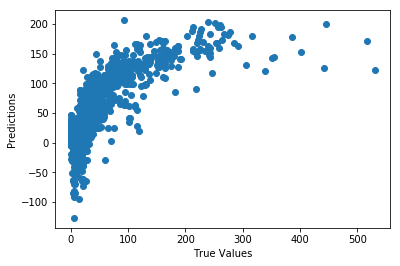

In [23]:
# prediction no cap
plot_scatter(test_labels, predictions)

In [ ]:
# Accuracy of linear regression
def calculate_percent_error_lr(test_predictions, test_labels):
    difference = abs(test_predictions - test_labels)
    error = difference / test_labels
    unprocessed_error_percentage = error * 100
    
    np_error = np.array(unprocessed_error_percentage)
    a = np.ma.masked_invalid(np_error)
    error_percentage = a.sum() / (len(unprocessed_error_percentage) - np.count_nonzero(np.isinf(unprocessed_error_percentage)))

    print(error_percentage)
    return (error_percentage)
np_test_labels = test_labels.values
percent_error_lr = calculate_percent_error_lr(predictions, np_test_labels)
compute_acc(percent_error_lr)
print(len(predictions))
print(len(test_labels))